## Pre-processing Steps for Plots

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib as mpl
import seaborn as sns
import h5py
import os
from utils import get_train_data

get_dir = os.getcwd()
os.chdir(get_dir)

In [2]:
def get_predictions_and_true_data(mdir, ddir, indices, sen_dir, tlim=1., dm=False):
    
    try:
        data = h5py.File(ddir)
    except:
        print("Provide the valid data directory, follow the instruction in the GitHub repo")
    sen_ind = pd.read_csv(sen_dir)['sensor_indices'].values.reshape(-1)
    print(sen_ind)
    model = tf.keras.models.load_model(mdir, safe_mode=True)
    
    xdisc = data['x-coordinate'][:]
    tdisc = data['t-coordinate'][:-1]
    X, T = np.meshgrid(xdisc, tdisc)
    
    x_sen = X[0, sen_ind].reshape(1, -1)
    t_sen = T[0, sen_ind].reshape(1, -1)
    tind = np.where(tdisc==tlim)[0].item() + 1
    
    u_pred = []
    u_true = []
    u_init = []
    err = []
    
    for i in indices:
        
        u_sen = data['tensor'][i, 0:1, :].squeeze()[sen_ind].reshape(1, -1)
        assert(u_sen.shape == x_sen.shape)
        xbc = np.repeat(x_sen, len(X[:tind, :].reshape(-1, 1)), axis=0)
        tbc = np.repeat(t_sen, len(X[:tind, :].reshape(-1, 1)), axis=0)
        ubc = np.repeat(u_sen, len(X[:tind, :].reshape(-1, 1)), axis=0)
        
        if dm:
            u_pred.append(model.predict([X[:tind, :].reshape(-1, 1), T[:tind, :].reshape(-1, 1), 
                                     ubc], batch_size=4096).reshape(X[:tind, :].shape))
        else:
            u_pred.append(model.predict([X[:tind, :].reshape(-1, 1), T[:tind, :].reshape(-1, 1),
                                         xbc, tbc,
                                         ubc], batch_size=4096).reshape(X[:tind, :].shape))
        u_true.append(data['tensor'][i, :tind, :].squeeze())
        u_init.append(data['tensor'][i, 0:1, :].reshape(-1))

    return X[:tind, :], T[:tind, :], u_pred, u_true, u_init

In [3]:
def get_plots(x, t, true_val, pred_val, init_val, grid_spec, plot_save, 
              plot_dir, fig_size, shrink=1, dm=False, lxd = [0.5, 0.5],lyd=[0.1, 0.9], 
              lx=0.25, rx=0.75, clim=[-1., 2.], eclim=[0., 0.08], cbar_kwargs=None, tlim=2., 
              value=None, init_value=None):
    
    fig, ax = plt.subplots(4, len(true_val), figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)
    
    # Create two GridSpec objects for left and right sections
    gs = mpl.gridspec.GridSpec(4, 4, figure=fig)
    level = np.linspace(clim[0], clim[1], num=10)
    err_level = np.linspace(eclim[0], eclim[1], num=7)
    tspan = t[:, 0].reshape(-1)
    tind = np.where(tspan==tlim)[0].item() + 1
    
    for j in range(len(true_val)):
        
        
        ax[0][j].plot(x[0, :], init_val[j], color='b', linewidth=1.)
        pre = ax[1][j].contourf(x[:tind, :], t[:tind, :], pred_val[j][:tind, :], level, cmap='rainbow')
        tru = ax[2][j].contourf(x[:tind, :], t[:tind, :], true_val[j][:tind, :], level, cmap='rainbow')
        err = abs(pred_val[j] - true_val[j])/(1 + abs(true_val[j]))
        if dm:
            err = ax[3][j].contourf(x[:tind, :], t[:tind, :], err[:tind, :], err_level, cmap='Blues', extend='both')
            err.cmap.set_under('orange')
            err.cmap.set_over('orange')
        else:
            err = ax[3][j].contourf(x[:tind, :], t[:tind, :], err[:tind, :],err_level, cmap='Blues')

        for row in ax[1:]:
            row[j].set_aspect(value, adjustable='box')    
        for row in ax[0:1]:
            row[j].set_aspect(init_value, adjustable='box')
        

    
    pcbar = fig.colorbar(pre, ax=ax[1, :], **cbar_kwargs)
    pcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
        
    tcbar = fig.colorbar(tru, ax=ax[2, :], **cbar_kwargs)
    tcbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
#   tcbar.set_label('U', fontsize=8, fontweight='bold')

    ecbar = fig.colorbar(err, ax=ax[3, :], **cbar_kwargs)
    ecbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
    
    ax[0][0].set_ylabel('Initial \n Conditions \n u(0, x)', fontsize=10, fontweight='bold')
    if dm:
        ax[1][0].set_ylabel('PI-DeepONets \n Solutions \n t', fontsize=10, fontweight='bold') 
    else:
        ax[1][0].set_ylabel('PINTO \n Solutions \n t', fontsize=10, fontweight='bold')
    ax[2][0].set_ylabel('Numerical \n Solutions \n t', fontsize=10, fontweight='bold')
    ax[3][0].set_ylabel('Relative Error \n t', fontsize=10, fontweight='bold') 
    ax[3][0].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[3][1].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[3][2].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[3][3].set_xlabel('X', fontsize=10, fontweight='bold')
    
    fig.text(lx, 0.9, 'Seen ICs', ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, 0.9, 'Unseen ICs', ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
        
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

In [4]:
def get_plots_slices(x, t, true_val, pred_val, grid_spec, plot_save, tint,
                     plot_dir, fig_size, shrink=1, lxd=[0.5, 0.5],lyd=[0.1, 0.9], 
                     lx=0.25, rx=0.75, clim=[-1., 2.], offset=(0, -10), dm=False, 
                     lgd=['PINTO', 'Numerical', 'PI-DeepONets'],
                     pid_pred=None, ncols=2):
    
    tspan = t[:, 0].reshape(-1)
    tlist = [np.where(tspan==tint[0])[0].item(), np.where(tspan==tint[1])[0].item(), np.where(tspan==tint[2])[0].item()]

    
    fig, ax = plt.subplots(3, len(true_val), figsize=fig_size, sharex='col', sharey='row', 
                           gridspec_kw =grid_spec)
    
    for j in range(len(true_val)):
        for k, i in enumerate(tlist):
            if (j==2 or j==3) and not dm:
                ind = np.argmax(pred_val[j][i, :].squeeze())
                px = x[0, ind]
                py = pred_val[j][i, ind]
            
                # Add marker point
                ax[k][j].plot(px, py, 'ro')  # red dot at the point

                # Add text marker (letter 'A' slightly above the point)
                ax[k][j].annotate('A', 
                    (px, py),
                    xytext=offset,        # 10 points vertical offset
                    textcoords='offset points',
                    ha='center',           # horizontal alignment
                    va='bottom',           # vertical alignment
                    fontsize=8,
                    fontweight='bold')
            
            ax[k][j].plot(x[0, :], pred_val[j][i, :], 'b', linewidth=1.5, label=lgd[0])
            ax[k][j].plot(x[0, :], true_val[j][i, :], '--', color='orange', linewidth=1.5,label=lgd[1])
            if pid_pred is not None:
                ax[k][j].plot(x[0, :], pid_pred[j][i, :], '-.', color='coral', linewidth=1.5, label=lgd[2] )
            ax[k][j].grid(True, which='major', linestyle='-', alpha=0.5)
            ax[k][j].grid(True, which='minor', linestyle='--', alpha=0.2)
            ax[k][j].minorticks_on()

        

    ax[0][0].legend(fancybox=False, frameon=False, ncols=2, fontsize=10, title_fontproperties={'weight':'bold'}, loc='lower center')
    ax[0][0].set_ylabel(f'u(t={tint[0]}, x)', fontsize=10, fontweight='bold')
    ax[1][0].set_ylabel(f'u(t={tint[1]}, x)', fontsize=10, fontweight='bold') 
    ax[2][0].set_ylabel(f'u(t={tint[2]}, x)', fontsize=10, fontweight='bold')
    ax[2][0].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[2][1].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[2][2].set_xlabel('X', fontsize=10, fontweight='bold')
    ax[2][3].set_xlabel('X', fontsize=10, fontweight='bold')
    
    fig.text(lx, 0.9, 'Seen ICs', ha='center', va='center', fontsize=12, fontweight='bold')
    fig.text(rx, 0.9, 'Unseen ICs', ha='center', va='center', fontsize=12, fontweight='bold')

    # Add vertical line using figure coordinates
    line = plt.Line2D(lxd, lyd, transform=fig.transFigure, color='black', linewidth=2)
    fig.add_artist(line)
    
        
    if plot_save:
        plt.savefig(plot_dir + '.png', dpi=300, bbox_inches = 'tight', format='png')

## Figure 2: Advection Equation

In [5]:
mdir = '../Trained_models/Advection_PINTO/Advection_model/'
ddir = '/mnt/PDE_Bench_data/1D_Advection_sols_beta01.hdf5'  #'../CFD_data/1D_Advection_sols_beta01.hdf5' 
sen_dir = '../Trained_models/Advection_PINTO/sensor.csv'
indices = [71, 25, 92, 90]
x, t, tno_pred_val, tno_true_val, init_val = get_predictions_and_true_data(mdir, ddir, indices, sen_dir, tlim=2.)

[ 836  523   89  915  270  347  122  801  666   99  485  700  483  267
  445  676  939  774  234 1019  449  571  290  760  376  470  607  738
  421  146  352  576  202  631  446  492  124  491  632  810   40  357
 1021  525   39  175  386  322  501  241  533  697  320   29  245  108
  214   60  373  672]
51/51 [==============================] - 1s 15ms/step


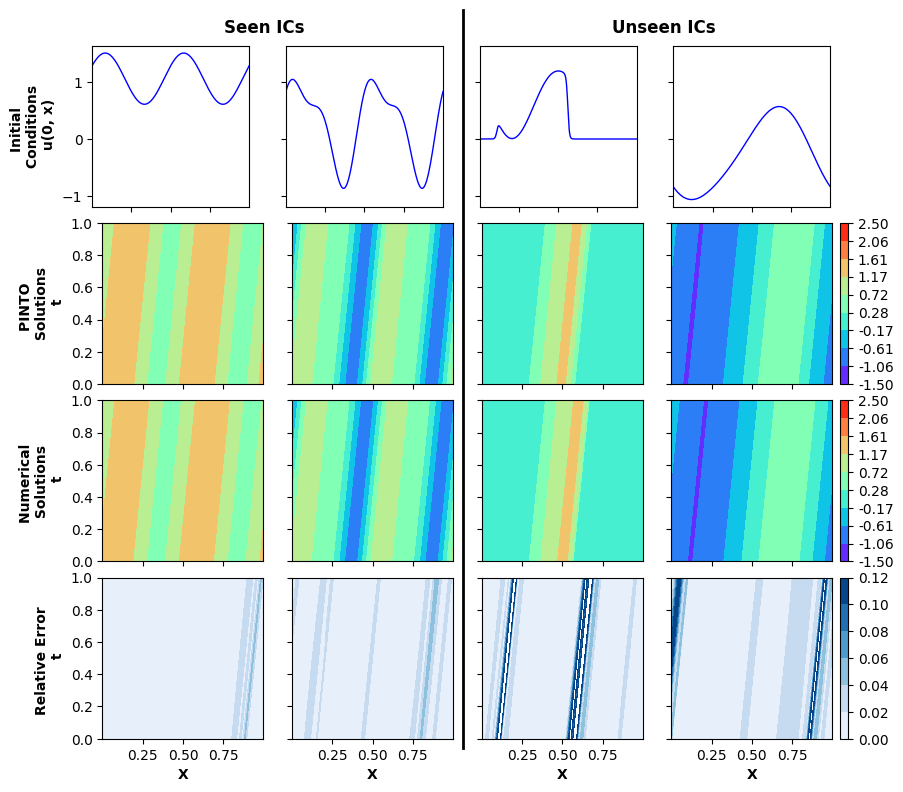

In [6]:
pdir = 'Figure_2.png'
plt_save = False # argument to save the plot
clim = [-1.5, 2.5] # contour plots colorbar limits
eclim = [0, 0.12] # relative error contours colorbar limits

grid_spec = {'wspace': 0.0, 'hspace': 0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1., 1, 1, 1]}
cbar_kwargs = {
        'fraction': 0.0112, 
        'pad': 0.01,
        'format': tick.FormatStrFormatter('%.2f')
    }
get_plots(x,  t, 
          tno_true_val, tno_pred_val, init_val, plot_save=plt_save,
          grid_spec=grid_spec, plot_dir=pdir, fig_size=(10, 9), shrink=1, 
          lxd=[0.514, 0.514], lyd=[0.1, 0.92], 
          lx=0.315, rx=0.715, clim=clim, eclim=eclim, cbar_kwargs=cbar_kwargs, value=1./1.,  
          init_value=1./2.75, tlim=1.)

## Plots for PI_DeepONets

In [7]:
mdir = '../Trained_models/Advection_DeepONet/Deeponet_model.keras'
sen_dir = '../Trained_models/Advection_DeepONet/sensor.csv'
x, t, pid_pred_val, pid_true_val, init_val = get_predictions_and_true_data(mdir, ddir, indices, sen_dir, tlim=2., dm=True)

[ 836  523   89  915  270  347  122  801  666   99  485  700  483  267
  445  676  939  774  234 1019  449  571  290  760  376  470  607  738
  421  146  352  576  202  631  446  492  124  491  632  810   40  357
 1021  525   39  175  386  322  501  241  533  697  320   29  245  108
  214   60  373  672  395  199  160  635  755  726  919   78  904  359
  444 1014  188  746  651  719  112  281  118  865]
51/51 [==============================] - 0s 3ms/step


In [8]:
# pdir = 'PI_DeepONets_Advection_training_testing_plots'
# cbar_kwargs = {
#         'fraction': 0.0112, 
#         'pad': 0.01,
#         'format': tick.FormatStrFormatter('%.2f')
#     }
# grid_spec = {'wspace': 0.2, 'hspace': 0.1, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1, 1]}
# get_plots(x,  t, 
#           pid_true_val, pid_pred_val, init_val, plot_save=False,
#           grid_spec=grid_spec, plot_dir=pdir, fig_size=(10,8), shrink=1, dm=True, lxd=[0.512, 0.512], lyd=[0.1, 0.92], 
#           lx=0.315, rx=0.715, clim=[-1.5, 2.5], cbar_kwargs=cbar_kwargs, value=1./1., 
# 	  init_value=1./2.75, tlim=1.)

## Figure 3: Acvection Equation

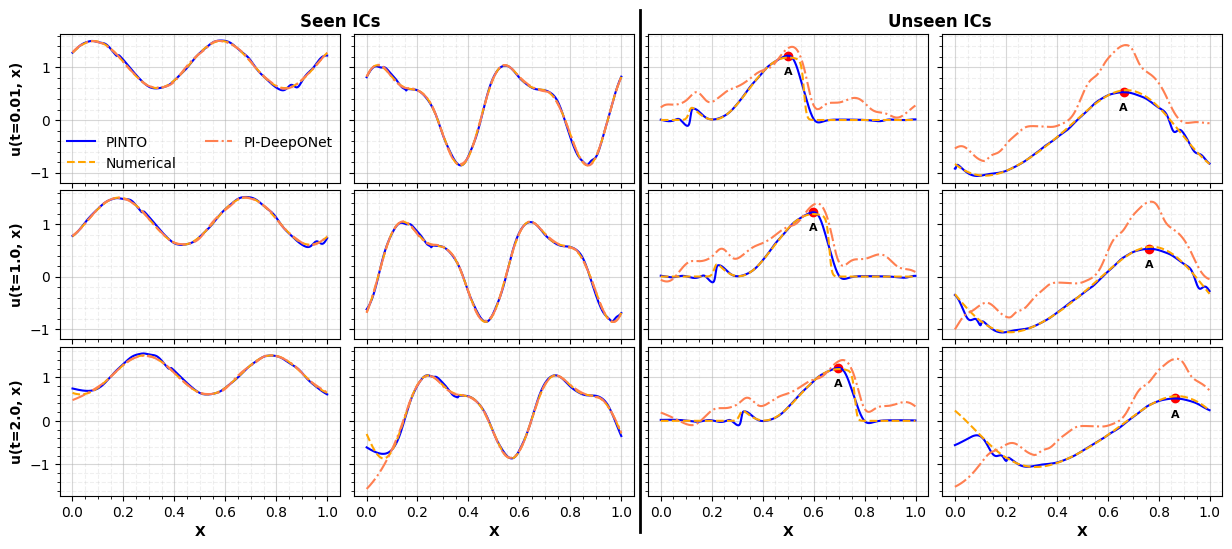

In [9]:
pdir = 'Figure_3.png'
plt_save = False # argument to save the plot
grid_spec = {'wspace': 0.05, 'hspace': 0.05, 'width_ratios':[1, 1, 1, 1], 'height_ratios':[1, 1, 1]}

get_plots_slices(x,  t, tno_true_val, tno_pred_val, plot_save=plt_save, tint=[0.01, 1., 2.],
                grid_spec=grid_spec, plot_dir=pdir, fig_size=(15,6), shrink=1, 
                lxd=[0.512, 0.512], lyd=[0.05, 0.92], 
                lx=0.312, rx=0.712, 
                offset=(0, -15), lgd=['PINTO', 'Numerical', 'PI-DeepONet'], 
		pid_pred=pid_pred_val, ncols=2)

## Figure 4: Learning curves during PINTO training for Advection equation 

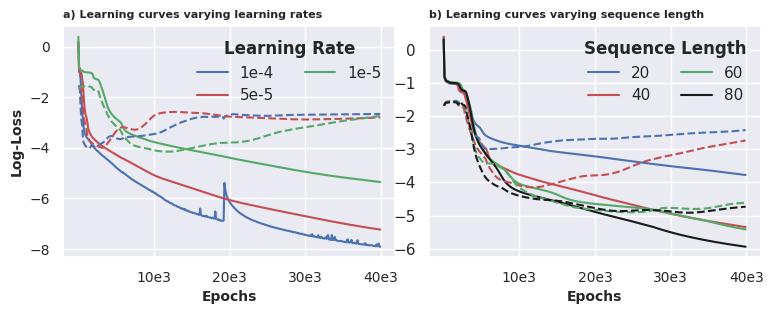

In [10]:
sns.set()

history_data1 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_1/history.csv')
history_data2 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_2/history.csv')
history_data3 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_3/history.csv')

val_history_data1 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_1/val_history.csv')
val_history_data2 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_2/val_history.csv')
val_history_data3 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_3/val_history.csv')

fig, ax = plt.subplots(1, 2, figsize=(9, 3), sharex='col', 
                       gridspec_kw={'wspace': 0.1, 'hspace': 0.2, 
                                    'width_ratios':[1, 1]})
ax[0].tick_params(axis='x',which='major',direction='out',width=2,labelsize=10)
ax[0].set_xticks([10000, 20000, 30000, 40000])
ax[0].set_xticklabels(['10e3', '20e3', '30e3', '40e3'])
ax[0].tick_params(axis='y',which='major',direction='out',width=2,labelsize=10)
epochs = np.arange(1, 40000, 100)
ax[0].plot(epochs, np.log(history_data1['loss'][::100]), 'b', label='1e-4')
ax[0].plot(epochs, np.log(history_data2['loss'][::100]), 'r', label='5e-5')
ax[0].plot(epochs, np.log(history_data3['loss'][::100]), 'g', label='1e-5')

ax[0].plot(epochs, np.log(val_history_data1['val_loss']), '--b')
ax[0].plot(epochs, np.log(val_history_data2['val_loss']), '--r')
ax[0].plot(epochs, np.log(val_history_data3['val_loss']), '--g')
ax[0].legend(title='Learning Rate', fancybox=False,frameon=False, loc='upper right', ncols=2,
             title_fontproperties={'weight':'bold'})
ax[0].set_xlabel('Epochs', fontsize=10, fontweight='bold')
ax[0].set_ylabel('Log-Loss', fontsize=10, fontweight='bold')
ax[0].set_title('a) Learning curves varying learning rates ',loc='left', fontsize=8, fontweight='bold')
plt.grid()

seq_data1 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_3/history.csv')
seq_data2 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_4/history.csv')
seq_data3 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_5/history.csv')
seq_data4 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_6/history.csv')

val_seq_data1 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_3/val_history.csv')
val_seq_data2 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_4/val_history.csv')
val_seq_data3 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_5/val_history.csv')
val_seq_data4 = pd.read_csv('../Trained_models/Hyperparameter_tuning/experiment_6/val_history.csv')

ax[1].tick_params(axis='x',which='major',direction='out',width=2,labelsize=10)
ax[1].set_xticks([10000, 20000, 30000, 40000])
ax[1].set_xticklabels(['10e3', '20e3', '30e3', '40e3'])

ax[1].plot(epochs, np.log(seq_data2['loss'][::100]), 'b', label='20')
ax[1].plot(epochs, np.log(seq_data1['loss'][::100]), 'r', label='40')
ax[1].plot(epochs, np.log(seq_data3['loss'][::100]), 'g', label='60')
ax[1].plot(epochs, np.log(seq_data4['loss'][::100]), 'k', label='80')

ax[1].plot(epochs, np.log(val_seq_data2['val_loss']), '--b')
ax[1].plot(epochs, np.log(val_seq_data1['val_loss']), '--r')
ax[1].plot(epochs, np.log(val_seq_data3['val_loss']), '--g')
ax[1].plot(epochs, np.log(val_seq_data4['val_loss']), '--k')

ax[1].legend(title='Sequence Length', fancybox=False, frameon=False, ncols=2, 
             title_fontproperties={'weight':'bold'}, loc='upper right')
ax[1].set_xlabel('Epochs', fontsize=10, fontweight='bold')
ax[1].set_title('b) Learning curves varying sequence length',loc='left', fontsize=8, fontweight='bold')

plt.grid()

# plt.savefig('Advection_learning_plots' + '.png', dpi=300, bbox_inches = 'tight', format='png')

## Table 1: Performance metrics: Overall Relative error for time interval of [0, 2] for PINTO and PI-DeepONet

In [11]:
def get_metrics(ddir, idx_sen, mdir, train_indices, test_indices, dm=False, tlim=1.):

	(txtrain, tttrain, tutrain, txbc_train, ttbc_train, tubc_train,
  txtest, tttest, tutest, txbc_test, ttbc_test, tubc_test) = get_train_data(data_dir=ddir, idx_sen=idx_sen, train_indices=train_indices, 
                                                              test_indices=test_indices, tlim=tlim)
	train_metric_mean = []
	test_metric_mean = []
	train_metric_std = []
	test_metric_std = []
	for i, j in enumerate(mdir):
		model = tf.keras.models.load_model(mdir[i])
		if dm:
			train_pred = model.predict([txtrain, tttrain, tubc_train], batch_size=4096)
			test_pred = model.predict([txtest, tttest, tubc_test], batch_size=4096)
		else:
			train_pred = model.predict([txtrain, tttrain, txbc_train, ttbc_train, tubc_train], batch_size=4096)
			test_pred = model.predict([txtest, tttest, txbc_test, ttbc_test, tubc_test], batch_size=4096)
  
		train_metric_mean.append(np.mean(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_mean.append(np.mean(abs((tutest - test_pred)/(1 + abs(tutest)))))
		train_metric_std.append(np.std(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_std.append(np.std(abs((tutest - test_pred)/(1 + abs(tutest)))))

	return pd.DataFrame({'train_metric_mean': train_metric_mean, 'test_metric_mean': test_metric_mean,
                      'train_metric_std': train_metric_std, 'test_metric_std': test_metric_std}) 

In [12]:
## PINTO-model

mdir = ['../Trained_models/Advection_PINTO/Advection_model/']
idx_sen = pd.read_csv('../Trained_models/Advection_PINTO/sensor.csv')['sensor_indices'].values
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(ddir, idx_sen, mdir, train_indices, test_indices, tlim=2.)
metrics

1000/1000 [==============================] - 9s 9ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
0,0.021109,0.028515,0.040147,0.047343


In [13]:
## PI-DeepONet model

mdir = ['../Trained_models/Advection_DeepONet/Deeponet_model.keras']
idx_sen = pd.read_csv('../Trained_models/Advection_DeepONet/sensor.csv')['sensor_indices'].values
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(ddir, idx_sen, mdir, train_indices, test_indices, dm=True, tlim=2.)
metrics

1000/1000 [==============================] - 4s 4ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
0,0.013065,0.112976,0.036992,0.11443


## Table A.2: Hyperparameter Tuning for Advection

In [14]:
def get_metrics(elist, ddir, idx_sen, mdir, train_indices, test_indices, dm=False, tlim=1., index=None):

	(txtrain, tttrain, tutrain, txbc_train, ttbc_train, tubc_train,
  txtest, tttest, tutest, txbc_test, ttbc_test, tubc_test) = get_train_data(data_dir=ddir, idx_sen=idx_sen, train_indices=train_indices, 
                                                              test_indices=test_indices, tlim=tlim)
	train_metric_mean = []
	test_metric_mean = []
	train_metric_std = []
	test_metric_std = []
	for i, j in enumerate(elist):
		model = tf.keras.models.load_model(mdir[i])
		if dm:
			train_pred = model.predict([txtrain, tttrain, tubc_train], batch_size=4096)
			test_pred = model.predict([txtest, tttest, tubc_test], batch_size=4096)
		else:
			train_pred = model.predict([txtrain, tttrain, txbc_train, ttbc_train, tubc_train], batch_size=4096)
			test_pred = model.predict([txtest, tttest, txbc_test, ttbc_test, tubc_test], batch_size=4096)
  
		train_metric_mean.append(np.mean(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_mean.append(np.mean(abs((tutest - test_pred)/(1 + abs(tutest)))))
		train_metric_std.append(np.std(abs((tutrain - train_pred)/(1 + abs(tutrain)))))
		test_metric_std.append(np.std(abs((tutest - test_pred)/(1 + abs(tutest)))))

	return pd.DataFrame({'train_metric_mean': train_metric_mean, 'test_metric_mean': test_metric_mean,
                      'train_metric_std': train_metric_std, 'test_metric_std': test_metric_std}, index=index)

In [15]:
elist = [7, 9, 1, 2, 3, 10] # [1, 2, 3, 4, 5, 8d]
base_dir = '../Trained_models/Hyperparameter_tuning/experiment_'
mdir = [ base_dir  + str(i) +'/experiment_' + str(i) + '_model' for i in elist ]
idx_sen = pd.read_csv(base_dir + str(7) + '/sensor.csv')['sensor_indices'].values
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(elist, ddir, idx_sen, mdir, train_indices, test_indices, tlim=1., 
                      index = ['Experiment_1', 'Experiment_2', 'Experiment_3', 'Experiment_4', 'Experiment_5',
                               'Experiment_8'])

metrics

500/500 [==============================] - 3s 7ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
Experiment_1,0.027907,0.080932,0.037245,0.217111
Experiment_2,0.045703,0.075739,0.064335,0.228270
Experiment_3,0.007933,0.079824,0.010388,0.138707
Experiment_4,0.010926,0.084348,0.015163,0.125823
Experiment_5,0.026668,0.072172,0.035813,0.114612
Experiment_8,0.027957,0.048872,0.036818,0.086734


In [16]:
elist = [11] # [9]
base_dir = '../Trained_models/Hyperparameter_tuning/experiment_'
mdir = [ base_dir  + str(i) +'/experiment_' + str(i) + '_model' for i in elist ]
idx_sen = pd.read_csv(base_dir + str(11) + '/sensor.csv')['sensor_indices'].values
# ddir = '/mnt/PDE_Bench_data/1D_Advection_sols_beta01.hdf5'
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(elist, ddir, idx_sen, mdir, train_indices, test_indices, tlim=1., 
                      index = ['Experiment_9'])
metrics

500/500 [==============================] - 4s 9ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
Experiment_9,0.017929,0.024793,0.022807,0.032138


In [17]:
# Sequence Length 60

elist = [5] #[6]
base_dir = '../Trained_models/Hyperparameter_tuning/experiment_'
mdir = [ base_dir + str(i) + '/experiment_' + str(i) + '_model' for i in elist ]
idx_sen = pd.read_csv(base_dir + str(5) + '/sensor.csv')['sensor_indices'].values
assert(len(idx_sen) == 60)
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(elist, ddir, idx_sen, mdir, train_indices, test_indices, tlim=1., index = ['Experiment_6'])

metrics

500/500 [==============================] - 3s 6ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
Experiment_6,0.020432,0.026083,0.028047,0.034373


In [19]:
# Sequence Length 80

elist = [6] #[7]
base_dir = '../Trained_models/Hyperparameter_tuning/experiment_'
mdir = [ base_dir + str(i) + '/experiment_' + str(i) + '_model' for i in elist ]
idx_sen = pd.read_csv(base_dir + str(6) + '/sensor.csv')['sensor_indices'].values
assert(len(idx_sen) == 80)
train_indices = np.arange(80)
test_indices = np.arange(80, 100)

metrics = get_metrics(elist, ddir, idx_sen, mdir, train_indices, test_indices, tlim=1., index = ['Experiment_7'])

metrics

500/500 [==============================] - 4s 8ms/step


,train_metric_mean,test_metric_mean,train_metric_std,test_metric_std
Experiment_7,0.016419,0.025339,0.020602,0.037822


## Appendix G: Computational Time 

In [ ]:
model = tf.keras.models.load_model('../Trained_models/Advection_PINTO/Advection_model/')

xdisc = np.linspace(0, 1, 1024)
tdisc = np.linspace(0, 1, 100)
X, T = np.meshgrid(xdisc, tdisc)
xin = X.reshape((-1, 1))
tin  = T.reshape((-1, 1))
x_sen = np.random.rand(len(xin), 60)
t_sen = np.random.rand(len(xin), 60)
u_sen = np.random.rand(len(xin), 60)

_ = model.predict([xin, tin , x_sen, t_sen, u_sen], batch_size=102400, verbose=0)
for i in range(10):
    _ = model.predict([xin, tin , x_sen, t_sen, u_sen], batch_size=102400)

1/1 [==============================] - 0s 39ms/step


: 